                    Pred 0 (Benign)  Pred 1 (Malign)
Verklig 0 (Benign)                4                1
Verklig 1 (Malign)                1                4


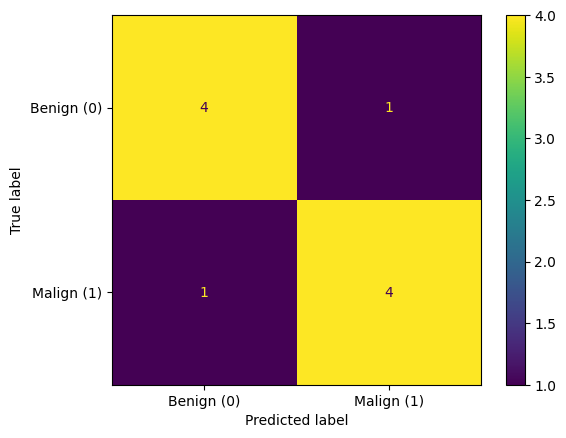

In [1]:
# Minimal, tydligt exempel: skapa och visa en confusion matrix i 5 rader kod (exkl. import).
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exempeldata
y_true = [0,1,1,0,1,0,0,1,1,0]
y_pred = [0,1,0,0,1,0,1,1,1,0]

# Skapa confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visa som DataFrame
df_cm = pd.DataFrame(cm, index=["Verklig 0 (Benign)", "Verklig 1 (Malign)"],
                     columns=["Pred 0 (Benign)", "Pred 1 (Malign)"])
print(df_cm)

# Visa grafiskt
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Benign (0)", "Malign (1)"])
disp.plot()
import matplotlib.pyplot as plt
plt.show()


=== Resultat för utvalda trösklar ===
 threshold  TN  FP  FN  TP  accuracy  precision  recall    f1  cost
       0.3  12   2   0   6      0.90       0.75   1.000 0.857    20
       0.5  14   0   0   6      1.00       1.00   1.000 1.000     0
       0.7  14   0   1   5      0.95       1.00   0.833 0.909  1000

=== Rekommenderad tröskel (minimerar kostnad) ===
threshold     0.41
TN           14.00
FP            0.00
FN            0.00
TP            6.00
accuracy      1.00
precision     1.00
recall        1.00
f1            1.00
cost          0.00


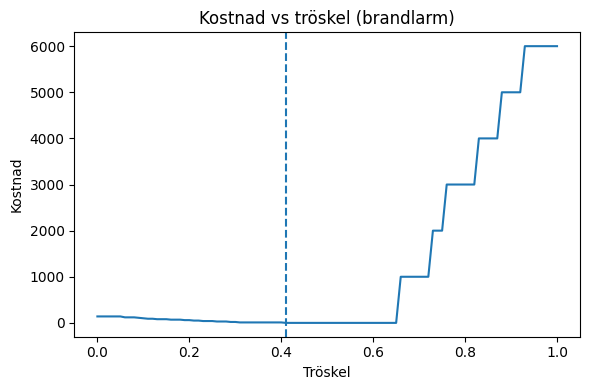

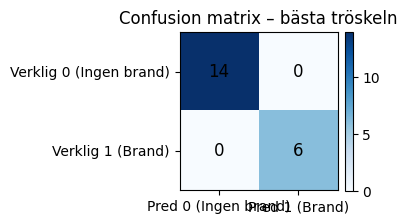

In [ ]:
# Brandlarm – tröskel, confusion matrix och kostnad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Exempeldata
# -----------------------------
# y_true: 1 = brand inträffade, 0 = ingen brand (facit)
y_true = np.array([0,0,0,0,1,0,0,1,0,0,  1,0,0,0,1,0,1,0,0,1])

# y_proba: modellens sannolikhet för "brand" (t.ex. rök + värme + partiklar)
y_proba = np.array([0.05,0.10,0.08,0.12,0.92,0.20,0.18,0.75,0.15,0.05,
                    0.87,0.25,0.30,0.40,0.72,0.28,0.65,0.22,0.09,0.83])

# -----------------------------
# 2) Hjälpfunktioner
# -----------------------------
def confusion_counts(y_true, y_pred):
    """Returnera TN, FP, FN, TP i den ordningen."""
    TN = int(((y_true==0)&(y_pred==0)).sum())
    FP = int(((y_true==0)&(y_pred==1)).sum())
    FN = int(((y_true==1)&(y_pred==0)).sum())
    TP = int(((y_true==1)&(y_pred==1)).sum())
    return TN, FP, FN, TP

def evaluate_threshold(thresh, y_true, y_proba):
    """Beräkna confusion matrix och nyckeltal för en given tröskel."""
    y_pred = (y_proba >= thresh).astype(int)
    TN, FP, FN, TP = confusion_counts(y_true, y_pred)
    total = len(y_true)
    accuracy  = (TP+TN)/total
    precision = TP/(TP+FP) if (TP+FP) else 0.0
    recall    = TP/(TP+FN) if (TP+FN) else 0.0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0
    return {"threshold": thresh, "TN":TN, "FP":FP, "FN":FN, "TP":TP,
            "accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}

# -----------------------------
# 3) Utvärdera några trösklar
# -----------------------------
thresholds = [0.30, 0.50, 0.70]
rows = [evaluate_threshold(t, y_true, y_proba) for t in thresholds]
df = pd.DataFrame(rows)

# Enkel kostnadsmodell: missa en brand (FN) är mycket dyrare än ett falskt larm (FP)
COST_FN = 1000   # t.ex. skada/konsekvens av att missa en brand
COST_FP = 10     # t.ex. onödig utryckning/avbrott
df["cost"] = df["FN"]*COST_FN + df["FP"]*COST_FP

print("=== Resultat för utvalda trösklar ===")
print(df.round(3).to_string(index=False))

# -----------------------------
# 4) Hitta bästa tröskeln enligt kostnadsmodellen
# -----------------------------
# Sök över ett tätare rutnät för att hitta minimum mer exakt
grid = np.linspace(0.0, 1.0, 101)
grid_rows = [evaluate_threshold(t, y_true, y_proba) for t in grid]
df_grid = pd.DataFrame(grid_rows)
df_grid["cost"] = df_grid["FN"]*COST_FN + df_grid["FP"]*COST_FP

best_idx = int(df_grid["cost"].idxmin())
best_row = df_grid.loc[best_idx]

print("\n=== Rekommenderad tröskel (minimerar kostnad) ===")
print(best_row.round(3).to_string())

# -----------------------------
# 5) Plotta kostnad vs tröskel
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(df_grid["threshold"], df_grid["cost"])
plt.axvline(best_row["threshold"], linestyle="--")
plt.title("Kostnad vs tröskel (brandlarm)")
plt.xlabel("Tröskel")
plt.ylabel("Kostnad")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) Visa confusion matrix för den bästa tröskeln
# -----------------------------
def plot_confusion_matrix(TN, FP, FN, TP):
    cm = np.array([[TN, FP],
                   [FN, TP]])
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=12)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0 (Ingen brand)", "Pred 1 (Brand)"])
    ax.set_yticklabels(["Verklig 0 (Ingen brand)", "Verklig 1 (Brand)"])
    ax.set_title("Confusion matrix – bästa tröskeln")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

TN, FP, FN, TP = confusion_counts(y_true, (y_proba >= best_row["threshold"]).astype(int))
plot_confusion_matrix(TN, FP, FN, TP)


=== Resultat för utvalda trösklar ===
 threshold  TN  FP  FN  TP  accuracy  precision  recall    f1  cost
       0.3  20   0   0  10       1.0        1.0     1.0 1.000     0
       0.5  20   0   0  10       1.0        1.0     1.0 1.000     0
       0.7  20   0   3   7       0.9        1.0     0.7 0.824    15

=== Rekommenderad tröskel (minimerar kostnad) ===
threshold     0.23
TN           20.00
FP            0.00
FN            0.00
TP           10.00
accuracy      1.00
precision     1.00
recall        1.00
f1            1.00
cost          0.00


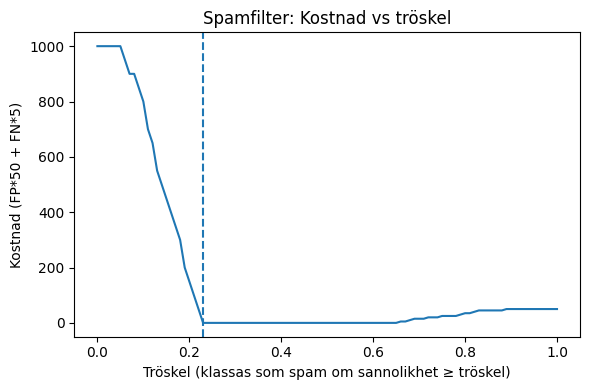

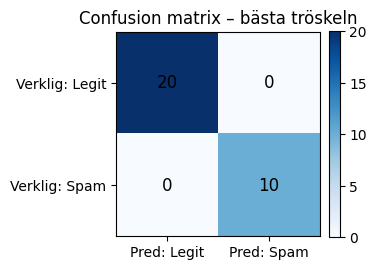

In [3]:
# Spamfilter – tröskel, confusion matrix och kostnad
# Kräver: numpy, pandas, matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Exempeldata
# -----------------------------
# y_true: 1 = spam, 0 = legitimt mejl
y_true = np.array([
    0,0,0,1,0, 1,0,0,1,0,
    0,1,0,0,1, 0,0,1,0,0,
    1,0,0,0,1, 0,1,0,0,1
])

# Modellens spam-sannolikheter (t.ex. från logistic regression)
y_proba = np.array([
    0.10,0.05,0.15,0.82,0.22, 0.78,0.18,0.12,0.65,0.09,
    0.06,0.71,0.20,0.14,0.74, 0.11,0.13,0.67,0.16,0.08,
    0.88,0.12,0.10,0.18,0.79, 0.17,0.69,0.21,0.19,0.83
])

# -----------------------------
# 2) Hjälpfunktioner
# -----------------------------
def confusion_counts(y_true, y_pred):
    TN = int(((y_true==0)&(y_pred==0)).sum())  # Rätt: legitimt ej blockat
    FP = int(((y_true==0)&(y_pred==1)).sum())  # FEL: legitimt hamnar i spam (dyrt!)
    FN = int(((y_true==1)&(y_pred==0)).sum())  # FEL: spam slinker igenom
    TP = int(((y_true==1)&(y_pred==1)).sum())  # Rätt: spam blockeras
    return TN, FP, FN, TP

def evaluate_threshold(thresh, y_true, y_proba):
    y_pred = (y_proba >= thresh).astype(int)
    TN, FP, FN, TP = confusion_counts(y_true, y_pred)
    total = len(y_true)
    accuracy  = (TP+TN)/total
    precision = TP/(TP+FP) if (TP+FP) else 0.0     # "När vi säger spam, hur ofta rätt?"
    recall    = TP/(TP+FN) if (TP+FN) else 0.0     # "Hur mycket av allt spam fångar vi?"
    f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0
    return {"threshold": thresh, "TN":TN, "FP":FP, "FN":FN, "TP":TP,
            "accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}

# -----------------------------
# 3) Utvärdera trösklar + kostnad
# -----------------------------
# Kostnadsantaganden (ändra gärna):
COST_FP = 50    # viktigt mejl felaktigt i spam (dyrt för användaren)
COST_FN = 5     # spam missas (irriterande men ofta mindre dyrt än FP)

thresholds = [0.30, 0.50, 0.70]
rows = [evaluate_threshold(t, y_true, y_proba) for t in thresholds]
df = pd.DataFrame(rows)
df["cost"] = df["FP"]*COST_FP + df["FN"]*COST_FN

print("=== Resultat för utvalda trösklar ===")
print(df.round(3).to_string(index=False))

# Finare sök över många trösklar för att hitta minsta kostnad
grid = np.linspace(0, 1, 101)
df_grid = pd.DataFrame([evaluate_threshold(t, y_true, y_proba) for t in grid])
df_grid["cost"] = df_grid["FP"]*COST_FP + df_grid["FN"]*COST_FN

best_idx = int(df_grid["cost"].idxmin())
best = df_grid.loc[best_idx]

print("\n=== Rekommenderad tröskel (minimerar kostnad) ===")
print(best.round(3).to_string())

# -----------------------------
# 4) Plotta kostnad vs tröskel
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(df_grid["threshold"], df_grid["cost"])
plt.axvline(best["threshold"], linestyle="--")
plt.title("Spamfilter: Kostnad vs tröskel")
plt.xlabel("Tröskel (klassas som spam om sannolikhet ≥ tröskel)")
plt.ylabel("Kostnad (FP*{} + FN*{})".format(COST_FP, COST_FN))
plt.tight_layout()
plt.show()

# -----------------------------
# 5) Visa confusion matrix vid bästa tröskeln
# -----------------------------
def plot_confusion_matrix(TN, FP, FN, TP):
    cm = np.array([[TN, FP],
                   [FN, TP]])
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=12)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred: Legit", "Pred: Spam"])
    ax.set_yticklabels(["Verklig: Legit", "Verklig: Spam"])
    ax.set_title("Confusion matrix – bästa tröskeln")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

y_pred_best = (y_proba >= best["threshold"]).astype(int)
TN, FP, FN, TP = confusion_counts(y_true, y_pred_best)
plot_confusion_matrix(TN, FP, FN, TP)
